In [27]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from scipy.special import gamma, factorial, zeta, polygamma
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from scipy.signal import argrelextrema

In [ ]:
def V0(phi, m, l):
    """
    The tree level potential V(phi) = -1/2 m^2 phi^2 + l/4 phi^4
    m is the tree-level mass and l the self-coupling, both should be positive

    @param phi: our scalar field, should be array
           m: the tree-level mass
           l: the self-coupling
    @return The effective potential at tree level
    """
    return -m**2*phi**2/2 + l*phi**4/4

In [ ]:
def JBexact(m, T):
    """
    The exact calculation of the thermal bosonic function J_B
    J_B[m^2/T^2] = int dx x^2 log[1 - exp(-sqrt(x^2 + m^2/T^2))] int from 0 to infinity
    Used in the one-loop thermal correction to the effective potential

    @param m: the mass of the boson, should be Python scalar, i.e no array
           T: the temperature, should be Python scalar, i.e no array
    @return JB: The thermal bosonic function
    """
    # The integrand
    f = lambda x: x**2*np.log(1 - np.exp(-np.sqrt(x**2 + m**2/T**2)))

    # scipy.integrate.quad can only take python scalars as input hence no arrays
    JB = integrate.quad(f, 0, np.inf)[0]
    return JB

In [ ]:
def JBhighTapprox(m, T):
    """
    The high temperature expansion of the bosonic thermal function
    J_B[m^2/T^2] = -pi^4/45 + pi^2/12*(m^2/T^2) - pi/6(m^2/T^2)^(3/2) 
                     (- 1/32*(m^2/T^2)^2 log(m^2/aB*T^2))                    aB = 16pi^2exp(3/2 - 2gamma_E), logaB = 5.4076
                            (- 2*pi^(7/2) sum(-1)^n zeta(2n+1)/(n+1)! gamma(n+1/2) (m^2/(4pi^2T^2))^(n+2) with summation over n from 1 to infinity)
                     (not yet implemented)

    @param m: the mass of the boson
           T: the temperature
    @return JBapprox: The high T-approximation of the thermal bosonic function
    """
    y = m**2/T**2
    JBapprox = -np.pi**4/45 + np.pi**2/12*y - np.pi/6*y**(3/2)
    return JBapprox
    

In [ ]:
def JFexact(m, T):
    """
    The exact calculation of the fermionic thermal function J_F
    J_B[m^2/T^2] = int dx x^2 log[1 + exp(-sqrt(x^2 + m^2/T^2))] int from 0 to infinity
    Used in the one-loop thermal correction to the effective potential

    @param m: the mass of the fermion, should be Python scalar, i.e no array
           T: the temperature, should be Python scalar, i.e no array
    @return JF: The thermal fermionic function
    """
    # The integrand
    f = lambda x: x**2*np.log(1 + np.exp(-np.sqrt(x**2 + m**2/T**2)))

    # scipy.integrate.quad can only take python scalars as input hence no arrays
    JF = integrate.quad(f, 0, np.inf)[0]
    return JF

In [ ]:
def JFhighTapprox(m, T):
    """
    The high temperature expansion of the fermionic thermal function
    J_B[m^2/T^2] = 7pi^4/360 - pi^2/24*(m^2/T^2)  
                     (- 1/32*(m^2/T^2)^2 log(m^2/aF*T^2))                    aF = pi^2exp(3/2 - 2gamma_E), logaF = 2.6351
                            (- pi^(7/2)/4 sum((-1)^n zeta(2n+1)/(n+1)! (1 - 2^(-2n-1))gamma(n+1/2) (m^2/(4pi^2T^2))^(n+2)) with summation over n from 1 to infinity)
                     (not yet implemented)

    @param m: the mass of the fermion
           T: the temperature
    @return JFapprox: The high T-approximation of the fermionic thermal function
    """
    y = m**2/T**2
    JFapprox = np.pi**4*7/360 - np.pi**2/24*y
    return JFapprox

In [ ]:
def V1Texact(mB, mF, nB, nF, T):
    """
    The finite-temperature one-loop effective potential:
    
        V1T = T^4/(2pi^2)*[sum_B nB*JB(mB^2/T^2) + sum_F nF*JF(mF^2/T^2)]
            where sum_B/F sum the bosons/fermions that couples to the scalar, 
            nB/F is the degree of freedom for each boson/fermion,
            mB/F is the field dependent mass of each boson/fermion

    
    @param mB: the field dependent mass/masses of the boson/bosons, should be an array
           mF: the field dependent mass/masses of the fermion/fermions, should be an array
           nB: the degree of freedom for each boson, should be an array and equal length as mB
           nF: the degree of freedom for each fermion, should be an array and equal length as mF
           T: the temperature, should be Python scalar, i.e no array
    @return tempPotential: The finite-temperature one-loop effective potential
    """
    summation = 0

    # For the function JBexact to work we need to recast mB and nB to 1-D arrays 
    if not isinstance(mB, np.ndarray) and not isinstance(nB, np.ndarray):
        mB = np.array([mB])
        nB = np.array([nB])

    # Same for the fermionic part, we need to recast mF and nF to 1-D arrays 
    if not isinstance(mF, np.ndarray) and not isinstance(nF, np.ndarray):
        mF = np.array([mF])
        nF = np.array([nF])

    # First sum the bosonic part, call the function JBexact that excepts no arrays
    for i in range(mB.size):
        summation += nB[i]*JBexact(mB[i], T)

    # Sum the fermionic part, call the function JFexact
    for i in range(mF.size):
        summation += nF[i]*JFexact(mF[i], T)

    tempPotential = T**4/(2*np.pi**2)*summation
    return tempPotential


In [65]:
def Veff(mB, mF, nB, nF, T, phi, m, l):
    """
    The effective potential, the tree level potential + the finite-temperature one-loop:
        Veff(phi, T) = V0(phi) + V1(phi, T)

    @param mB: the field dependent mass/masses of the boson/bosons, should be an array
           mF: the field dependent mass/masses of the fermion/fermions, should be an array
           nB: the degree of freedom for each boson, should be an array and equal length as mB
           nF: the degree of freedom for each fermion, should be an array and equal length as mF
           T: the temperature
           phi: our scalar field, should be array
           m: the tree-level mass of the scalar
           l: the self-coupling of the scalar
    @return The effective potential
    """
    
    return V0(phi, m) + V1Texact(mB, mF, nB, nF, T)

In [39]:
m1 = 0.5*1**2
m2 = 1
m1 = np.asanyarray(m1)
m2 = np.asanyarray(m2)
massSq = np.empty(m1.shape + (5,))
print(massSq)
massSq[0] = m1
massSq[1] = m2
print(massSq)

[0.5 1.  0.5 0.  0. ]
[0.5 1.  0.5 0.  0. ]


In [51]:
T = 1
m = 2
y = m**2/T**2
print(y)
f = lambda x: x**2*np.log(1 - np.exp(-np.sqrt(x**2 + y)))
JB = integrate.quad(f, 0, np.inf)[0]
print(JB)

a = np.array([1, 2, 3])
b = np.array([1, 2, 3])
np.sum(a*b)

4.0
-1.0332425147778947


14

In [64]:
mB = 2
print(type(mB))
if not isinstance(mB, np.ndarray):
        mB = np.array([mB])

print(mB.shape)
print(mB[0])

<class 'int'>
(1,)
2


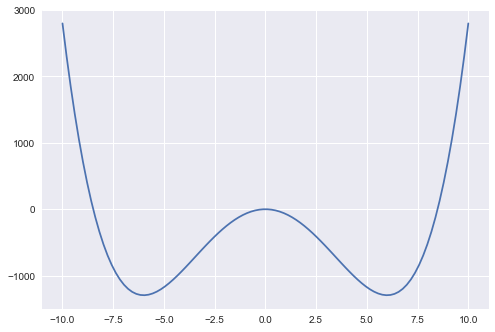

In [76]:
"""
Testing testing
"""
# Define a tree level potential V(phi) = -12^2/2*phi^2 + phi^4
m = 12
l = 4
phi_span = np.linspace(-10, 10, 100)
pot = V0(phi_span, m, l)

# Plot the tree level potential
plt.figure()
plt.plot(phi_span, pot, label='$V(\phi)$')

# Define the field dependent masses
# Phi
mPhi = m**2 + l*phi_span**2/2 #oklar
# Extra boson
c = 1
mX = c**2*phi_span**2

# Behöver boson för att få termen ~Tphi^3 som ger 1st order PT kanske räcker med phi, alt lägg till extra boson



TO DO:
- fixa field dependent masses, array i 1-D/2-D till scalar i JB/Fexact
- kolla integralen, går den att summera ihop för olika phi-värden som ger olika m-värden
- sätta upp mB som ([e, n, b], [e, n, a, n, n, a, n])??
- testa med approx ist, använda phi_span men kolla specifika temperaturer